This notebook takes the predictions from our various models and combines them into one dataframe and then uses gradient boosting ensemble methods to calculate the final predictions. We begin by loading the data and creating a few helper methods for later use.

In [291]:
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

In [292]:
##helper methods
def simple_rmse(model, X, Y):
    y_pred = model.predict(X)
    rmse = -np.sqrt(mean_squared_error(y_pred, Y))
    return rmse

def rmse_cv(model, X_train, y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def plot_it(model, case):
    if case == 1:
        model.fit(tp, tpl)
        preds = model.predict(dp)
    elif case == 2:
        model.fit(tp2, tpl2)
        preds = model.predict(dp2)
    elif case == 3:
        model.fit(tp3, tpl3)
        preds = model.predict(dp3)
    
    deltas = preds-dpl
    print "mean: %3.4f" %np.mean(deltas)
    print "standard deviation: %3.4f" %np.std(deltas)
    
    plt.scatter(dpl,preds)
    plt.xlim((10,14.0))
    plt.ylim((10,14.0))
    plt.plot(range(10,15), range(10,15));
    
def plot_pca(model, n):
    scores = []
    pca = PCA(n)
    pca_train = pca.fit_transform(train_split)
    pca_dev = pca.transform(dev)
    for i in range(n):
        model.fit(pca_train[:,0:i+1], train_split_labels)
        scores.append(-simple_rmse(model, pca_dev[:,0:i+1], dev_labels))
    
    plt.scatter(range(1,n+1),scores)
    plt.show()

In [293]:
##read in data
train = pd.read_csv('data/train_fe.csv',delimiter=',',header=0)
train = train.drop( ["SalePrice"], axis=1 )
train = train.drop(['Unnamed: 0'],axis=1)
train_split, dev, train_split_labels, dev_labels = train_test_split(train,train_labels, test_size = .5, random_state=207)
test = pd.read_csv('data/test_fe.csv',delimiter=',',header=0)
test = test.drop(['Unnamed: 0'],axis=1)

##get linear predictions
linear_dev_preds = pd.read_csv('data/linear_out_dev.csv',delimiter=',',header=0)
preds_labels = linear_dev_preds["Actual"].copy()
linear_dev_preds = linear_dev_preds.drop(['Actual'],axis=1)
linear_dev_preds = linear_dev_preds.drop(['Unnamed: 0'],axis=1)
linear_test_preds = pd.read_csv('data/linear_out_test.csv',delimiter=',',header=0)
linear_test_preds = linear_test_preds.drop(['Unnamed: 0'],axis=1)

##get nonlinear predictions
nl_dev_preds = pd.read_csv('data/nl_out_dev.csv',delimiter=',',header=0)
nl_dev_preds = nl_dev_preds.drop(['Actual'],axis=1)
nl_test_preds = pd.read_csv('data/nl_out_test.csv',delimiter=',',header=0)

##combine
train_x = pd.concat([nl_dev_preds, linear_dev_preds], axis=1)
test_x = pd.concat([nl_test_preds, linear_test_preds], axis=1)
train_y = preds_labels
# print train_x.shape
# print test_x.shape
# print nl_dev_preds.shape

# train_x = nl_dev_preds
# train_y = preds_labels
# test_x = nl_test_preds

##split linear predictions
tp, dp, tpl, dpl = train_test_split(train_x,preds_labels, test_size = .8, random_state=207)

print train_x.shape
print test_x.shape

(730, 5)
(1459, 5)


In [294]:
# from scipy.stats import skew
# train = pd.read_csv('data/train.csv',delimiter=',',header=0)
# test = pd.read_csv('data/test.csv',delimiter=',',header=0)

# all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
#                       test.loc[:,'MSSubClass':'SaleCondition']))

# numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index

# all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data = pd.get_dummies(all_data)

# all_data = all_data.fillna(all_data.mean())

# x = all_data[:train.shape[0]]
# test = all_data[train.shape[0]:]
# y = np.log(train.SalePrice)

# train = x.copy()
# train_labels = y.copy()
# train_split, dev, train_split_labels, dev_labels = train_test_split(train,train_labels, test_size = .5, random_state=207)

Again we perform a PCA analysis on the dev data to get a sense of the variation explained by the first 50 principal components so if we want to add the PCA data to assist in the ensemble predictions.

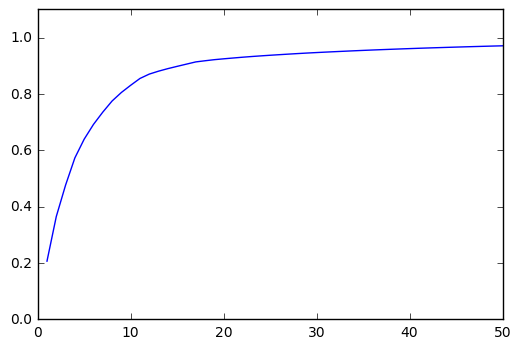

In [295]:
##pca
pca_test = PCA(50)
pca_x = pca_test.fit_transform(dev)
pca_x2 = pca_test.transform(test)

var = []
for a in range(50):
    var.append(np.sum(pca_test.explained_variance_ratio_[:a+1]))
    
plt.plot(range(1,51), var)
plt.ylim((0,1.1));

Here we combine the prediction data with the PCA data or the full test/train data for our ensemble predictions below.

In [296]:
##combine pca and predictions
pca_x = pd.DataFrame(pca_x)
pca_x2 = pd.DataFrame(pca_x2)
comb = pd.concat([train_x, pca_x], axis=1)
comb_test = pd.concat([test_x, pca_x2], axis=1)
comb2 = pd.concat([train_x, dev.reset_index()], axis=1)
comb2 = comb2.drop("index", axis=1)
comb2_test = pd.concat([test_x, test], axis=1)

tp2, dp2, tpl2, dpl2 = train_test_split(comb,preds_labels, test_size = .8, random_state=207)
tp3, dp3, tpl3, dpl3 = train_test_split(comb2,preds_labels, test_size = .8, random_state=207)

The following three models are tuned using gridsearchcv to make predictions on 3 versions of the data.
1. Just the predictions from the best performing linear and non linear models
2. The predictions plus the first 50 PCA
3. The predictions plus the full original data

Similarly to the non linear model notebook we present information on the tuning and how the predictions fare.

131.306999922
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.114381902753
{'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 1}


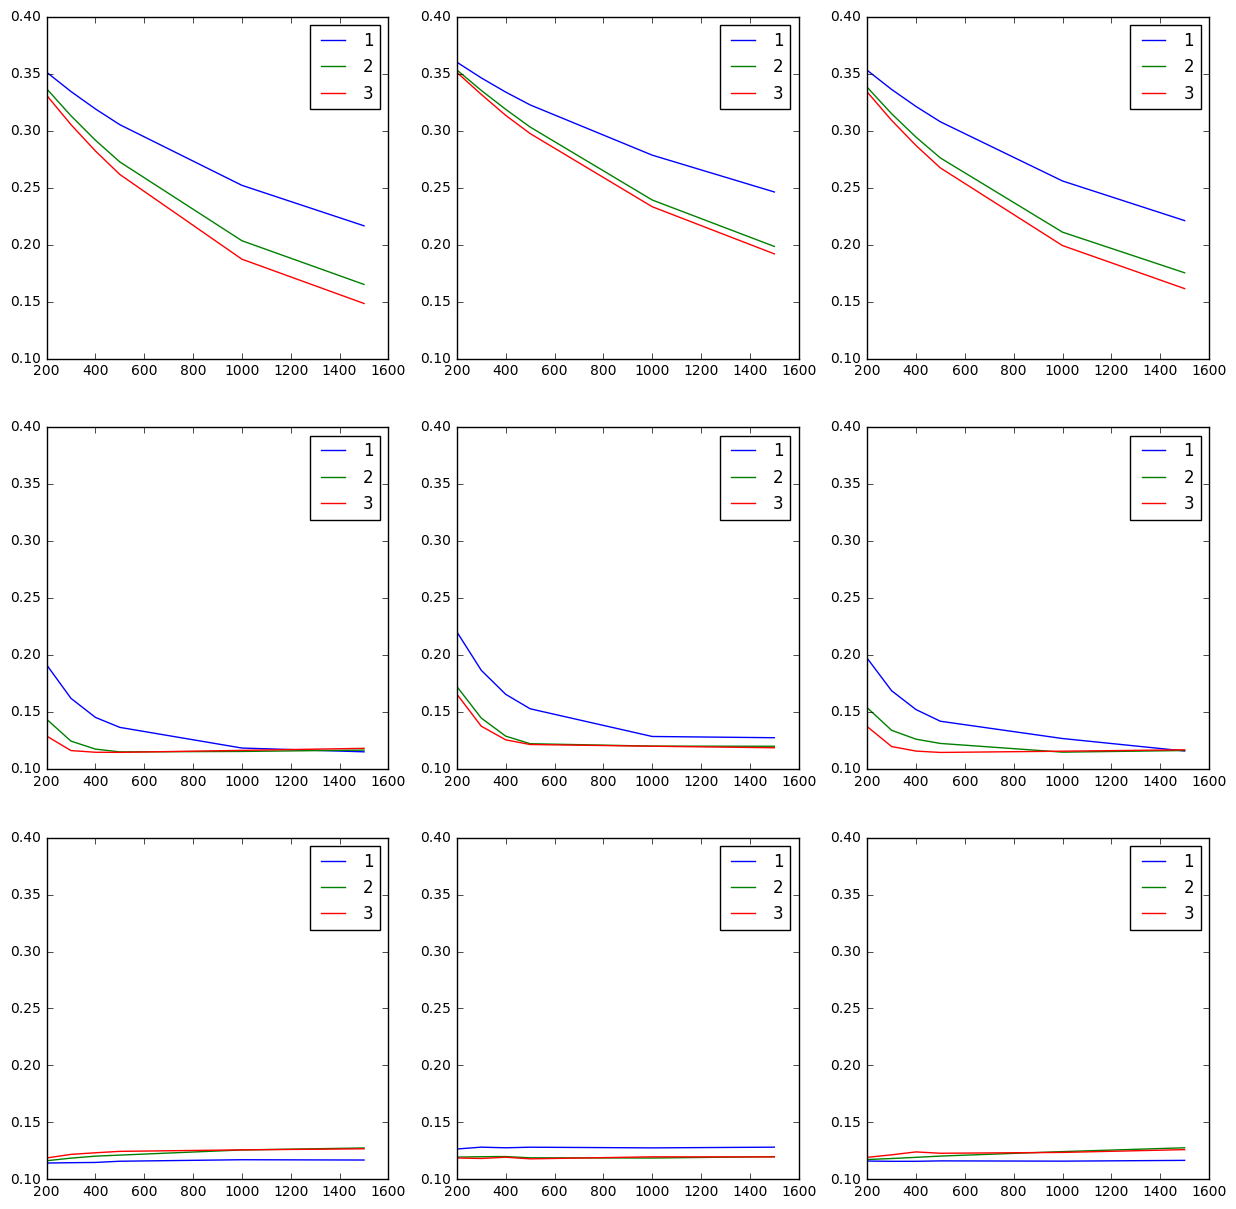

In [297]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,300,400, 500, 1000, 1500]
md = [1,2,3]
lr = [.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls", "lad", "huber"]}
gs3 = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3.fit(train_x,train_y)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_

f, axarr = plt.subplots(len(lr), 3)
for b,val2 in enumerate(lr):
    for c in range(3):
        for a,val in enumerate(md):
            start = len(est)*a+len(est)*len(md)*c+len(est)*len(md)*3*b
            end = len(est)*a+len(est)*len(md)*c+len(est)*len(md)*3*b + len(est)
            axarr[b,c].plot(est,-gs3.cv_results_['mean_test_score'][start:end], label=val)
            axarr[b,c].legend()
            axarr[b,c].set_ylim((0.1,.4))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5 * 3)
f.show;

mean: 0.0074
standard deviation: 0.1359


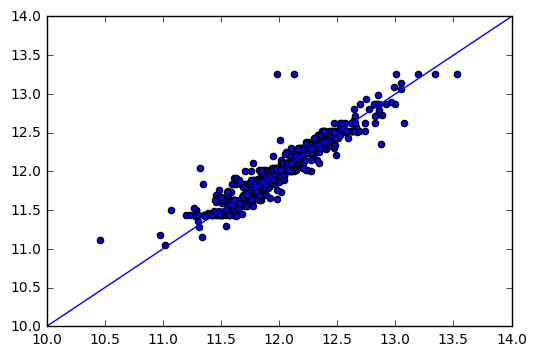

In [298]:
##best version
ls_gbr_best = GBR(n_estimators =gs3.best_params_['n_estimators'],max_features =gs3.best_params_['max_features'], max_depth =gs3.best_params_['max_depth'], learning_rate =gs3.best_params_['learning_rate'], loss=gs3.best_params_['loss'])
plot_it(ls_gbr_best, 1)

512.36500001
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.119172129317
{'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 1}


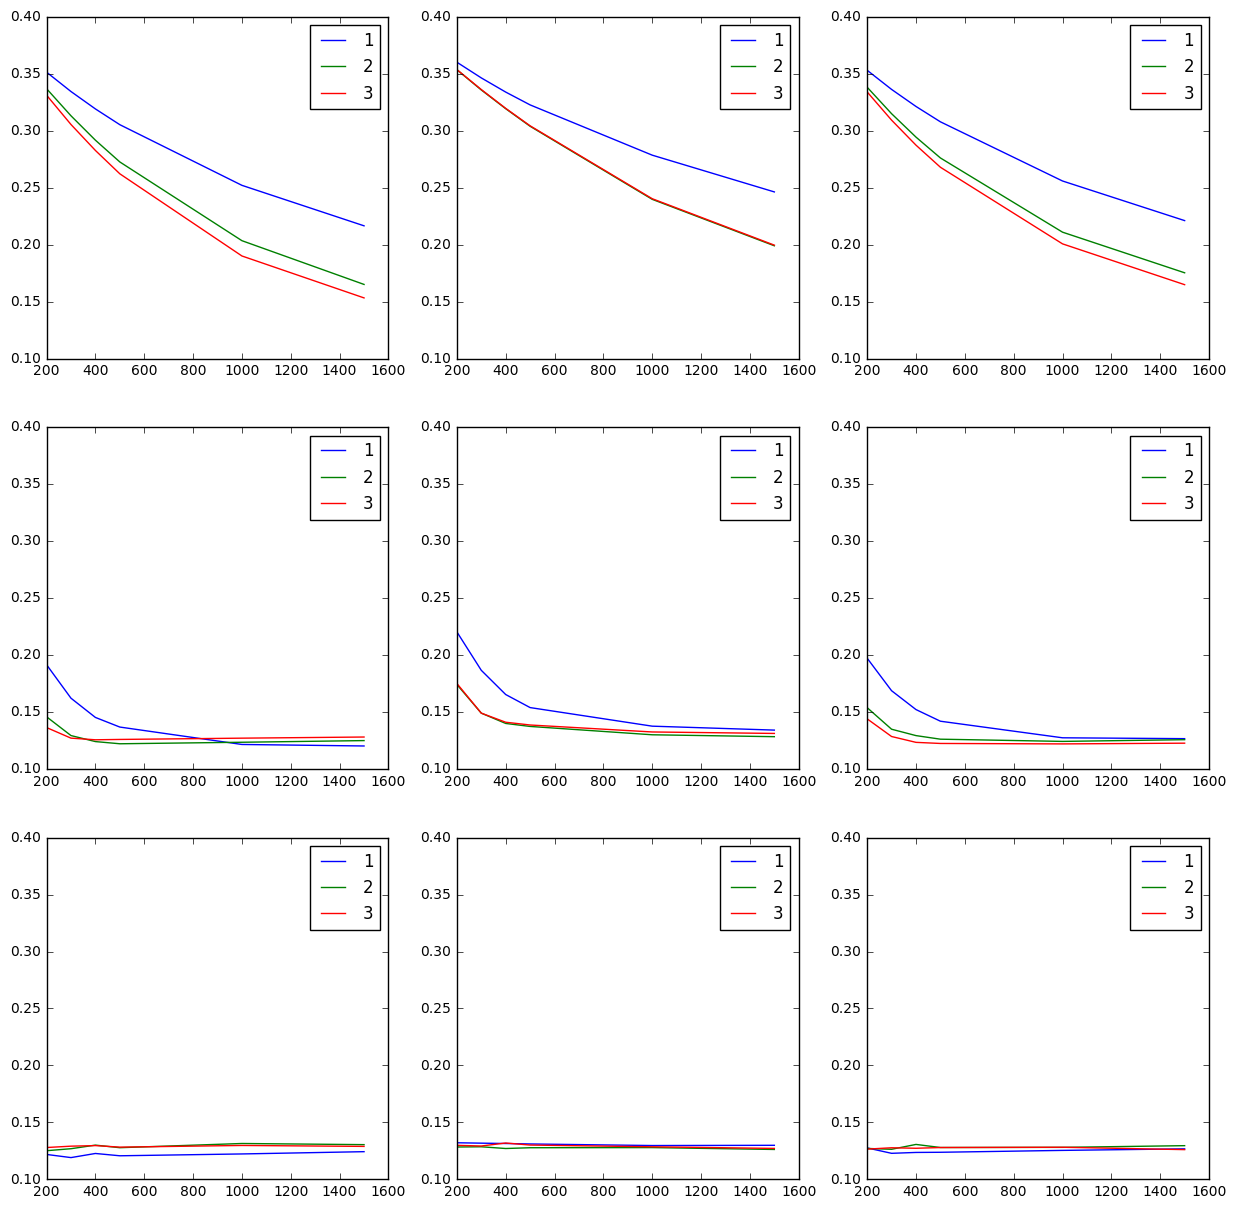

In [299]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,300,400, 500, 1000, 1500]
md = [1,2,3]
lr = [.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls", "lad", "huber"]}
gs3b = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3b.fit(comb,train_y)
end = time.time()
print end-start
print gs3b.best_estimator_
print gs3b.best_score_
print gs3b.best_params_

f, axarr = plt.subplots(len(lr), 3)
for b,val2 in enumerate(lr):
    for c in range(3):
        for a,val in enumerate(md):
            start = len(est)*a+len(est)*len(md)*c+len(est)*len(md)*3*b
            end = len(est)*a+len(est)*len(md)*c+len(est)*len(md)*3*b + len(est)
            axarr[b,c].plot(est,-gs3b.cv_results_['mean_test_score'][start:end], label=val)
            axarr[b,c].legend()
            axarr[b,c].set_ylim((0.1,.4))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5 * 3)
f.show;

mean: 0.0078
standard deviation: 0.1425


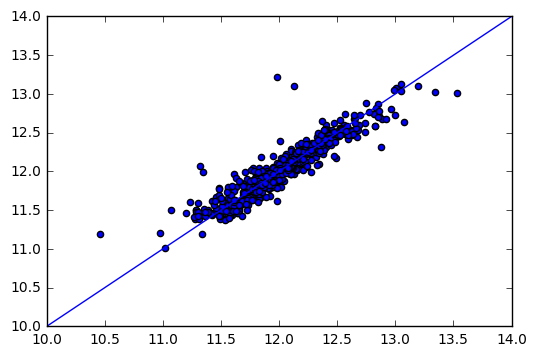

In [300]:
##best version
ls_gbr_best2 = GBR(n_estimators =gs3b.best_params_['n_estimators'],max_features =gs3b.best_params_['max_features'], max_depth =gs3b.best_params_['max_depth'], learning_rate =gs3b.best_params_['learning_rate'], loss=gs3b.best_params_['loss'])
plot_it(ls_gbr_best2, 2)

800.632999897
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.114381902753
{'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 1}


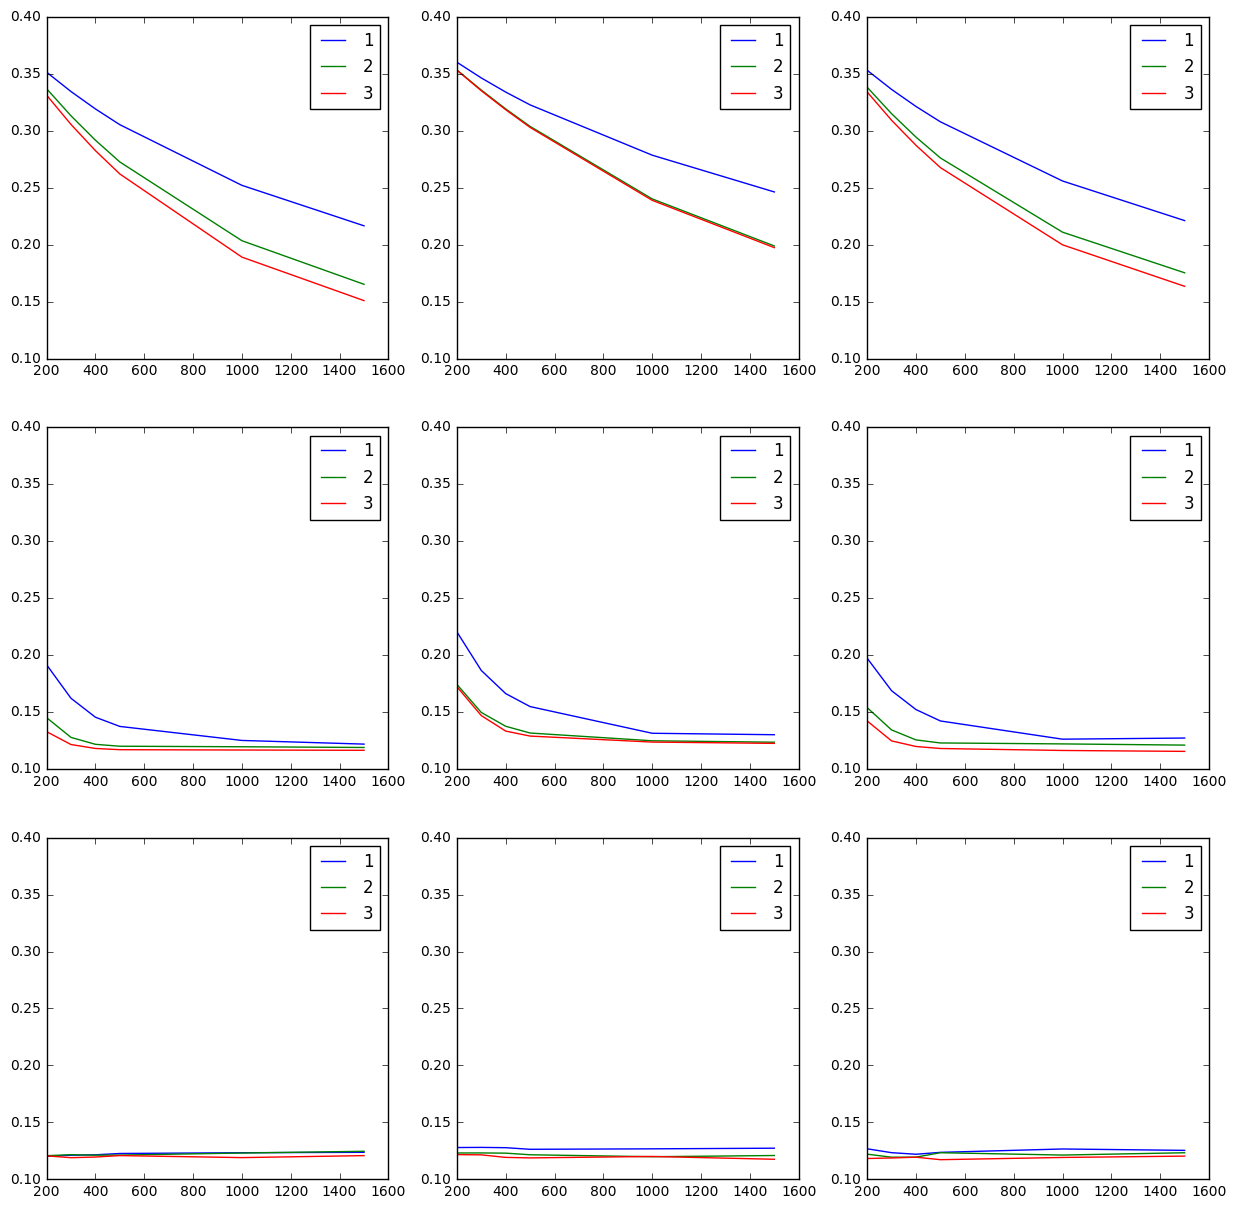

In [301]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,300,400, 500, 1000, 1500]
md = [1,2,3]
lr = [.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls", "lad", "huber"]}
gs3c = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3c.fit(comb2,train_y)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_


f, axarr = plt.subplots(len(lr), 3)
for b,val2 in enumerate(lr):
    for c in range(3):
        for a,val in enumerate(md):
            start = len(est)*a+len(est)*len(md)*c+len(est)*len(md)*3*b
            end = len(est)*a+len(est)*len(md)*c+len(est)*len(md)*3*b + len(est)
            axarr[b,c].plot(est,-gs3c.cv_results_['mean_test_score'][start:end], label=val)
            axarr[b,c].legend()
            axarr[b,c].set_ylim((0.1,.4))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5 * 3)
f.show;

mean: 0.0068
standard deviation: 0.1333


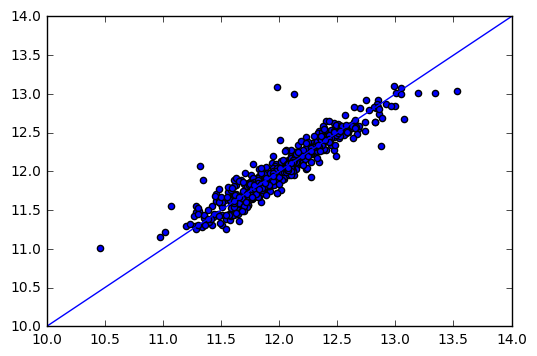

In [302]:
##best version
ls_gbr_best3 = GBR(n_estimators =gs3c.best_params_['n_estimators'],max_features =gs3c.best_params_['max_features'], max_depth =gs3c.best_params_['max_depth'], learning_rate =gs3c.best_params_['learning_rate'], loss=gs3c.best_params_['loss'])
plot_it(ls_gbr_best3, 3)

Finally we output the results by running predictions with the models tuned using their best parameters found above.

We use two output files.
1. Includes the mean of the three ensemble models using just predictions, predictions and PCA, and predictions and full data
2. The second file includes 4 columns:
  1. The predictions just for the ensemble model with only predictions
  2. The predictions for the ensemble model with predictions and PCA
  3. The predictions for the ensemble model with predictions and full data
  4. The simple mean of the best performing nonlinear and linear models

In [303]:
##output results
ls_gbr_best.fit(train_x, train_y)
ls_gbr_best2.fit(comb, train_y)
ls_gbr_best3.fit(comb2, train_y)

preds1 = np.exp(ls_gbr_best.predict(test_x))
preds2 = np.exp(ls_gbr_best2.predict(comb_test))
preds3 = np.exp(ls_gbr_best3.predict(comb2_test))

mean = np.exp(np.mean(test_x, axis=1))

allpreds = {"PredsOnly": preds1,
           "PredsPCA": preds2,
           "PredsTest": preds3,
           "Mean": mean}

preds_array = np.array([preds1,preds2,preds3])
means = np.mean(preds_array, axis=0)
price = {"SalePrice": means}
preds = pd.DataFrame(data = price)
preds2 = pd.DataFrame(data =allpreds)

preds.to_csv('data/final_preds.csv')
preds2.to_csv('data/final_preds_seperate.csv')